In [1]:
import pandas as pd
import numpy as np
import peptides
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
pd.set_option('display.max_columns', None)

In [2]:
#Load the peptide and HLA sequence dataset
df = pd.read_csv('/home/hamdaalhosani/features-pHLA-main/Data/big_data/Data_S3.csv')
print(df.head())
print(df.info())
df

        allele        peptide  measurement_value measurement_inequality
0  HLA-A*01:01      AAAALGRAP              100.0                      <
1  HLA-A*01:01   AAAGGGGGGGRY              100.0                      <
2  HLA-A*01:01       AAAHTHRY              100.0                      <
3  HLA-A*01:01   AADAVTGRTEEY              100.0                      <
4  HLA-A*01:01  AADDYNRIGSSLY              100.0                      <
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 677789 entries, 0 to 677788
Data columns (total 4 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   allele                  677227 non-null  object 
 1   peptide                 677227 non-null  object 
 2   measurement_value       677227 non-null  float64
 3   measurement_inequality  677227 non-null  object 
dtypes: float64(1), object(3)
memory usage: 20.7+ MB
None


,allele,peptide,measurement_value,measurement_inequality
0,HLA-A*01:01,AAAALGRAP,100.0,<
1,HLA-A*01:01,AAAGGGGGGGRY,100.0,<
2,HLA-A*01:01,AAAHTHRY,100.0,<
3,HLA-A*01:01,AADAVTGRTEEY,100.0,<
4,HLA-A*01:01,AADDYNRIGSSLY,100.0,<
...,...,...,...,...
677784,SLA-2*05:02,YTAQFHPEIF,555.0,=
677785,SLA-2*11:04,AMLRAATYY,1000.0,<
677786,SLA-2*11:04,ATRVTELLY,100.0,<
677787,SLA-2*11:04,TVYNGNCKY,5000.0,>


In [3]:
mask = df['allele'].str.startswith('HLA-A') | df['allele'].str.startswith('HLA-B') | df['allele'].str.startswith('HLA-C')

# Apply the mask to the dataframe to get a new dataframe
filtered_df = df[mask]
filtered_df

,allele,peptide,measurement_value,measurement_inequality
0,HLA-A*01:01,AAAALGRAP,100.0,<
1,HLA-A*01:01,AAAGGGGGGGRY,100.0,<
2,HLA-A*01:01,AAAHTHRY,100.0,<
3,HLA-A*01:01,AADAVTGRTEEY,100.0,<
4,HLA-A*01:01,AADDYNRIGSSLY,100.0,<
...,...,...,...,...
661261,HLA-C*17:01,YVINVTTHL,100.0,<
661262,HLA-C*17:01,YVQSMDVAAF,100.0,<
661263,HLA-C*17:01,YVVPYMIHL,100.0,<
661264,HLA-C*17:01,YVVPYTIHL,100.0,<


In [4]:
allele_counts = filtered_df['allele'].value_counts()

# Filter counts for alleles starting with HLA-A, HLA-B, and HLA-C
hla_a_count = filtered_df[filtered_df['allele'].str.startswith('HLA-A')]['allele'].nunique()
hla_b_count = filtered_df[filtered_df['allele'].str.startswith('HLA-B')]['allele'].nunique()
hla_c_count = filtered_df[filtered_df['allele'].str.startswith('HLA-C')]['allele'].nunique()

print("Number of unique alleles starting with HLA-A:", hla_a_count)
print("Number of unique alleles starting with HLA-B:", hla_b_count)
print("Number of unique alleles starting with HLA-C:", hla_c_count)

Number of unique alleles starting with HLA-A: 58
Number of unique alleles starting with HLA-B: 99
Number of unique alleles starting with HLA-C: 26


### Extracting Features 

In [5]:
from mhc_pseudo import mhc_pseudo
from features_utils import categorize, normalize_measurement_value, extract_features, label_category
## Mapping HLA alleles to their psudosequences 
df['hla_sequence'] = df['allele'].map(mhc_pseudo)

## Adding a qualitative data affinity column
df['category'] = df['measurement_value'].apply(categorize)

#Normalize the measurement valuespd.set_option('display.max_columns', None)

df['Normalized nM'] = normalize_measurement_value(df['measurement_value'])

df['label'] = df.apply(label_category, axis=1)
df['label'].value_counts()

positive    538485
negative    139304
Name: label, dtype: int64

In [6]:
### Creating Peptide IDs and allele IDs
peptide_to_id, unique_peptides = pd.factorize(df['peptide'])
allele_to_id, unique_allele = pd.factorize(df['allele'])
df['peptide_id'] = peptide_to_id
df['allele_id'] = allele_to_id
df = df.dropna()
df["label"].value_counts()

positive    531412
negative    129780
Name: label, dtype: int64

In [7]:
#Cleaning the peptides-HLA dataframe
peptide_df =df[['peptide_id', 'peptide']].drop_duplicates()
allele_df =df[['allele', 'hla_sequence', 'allele_id']].drop_duplicates()
seqs = peptide_df['peptide'].tolist()
hla_sequences = allele_df['hla_sequence'].tolist()

In [8]:
#Get the N and C terminal for each peptide sequence
peptide_df['N-terminal'] = peptide_df['peptide'].str[0] 
peptide_df['C-terminal'] = peptide_df['peptide'].str[-1] 

In [9]:
def get_hydrophobicity(amino_acid):
    peptide = peptides.Peptide(amino_acid)
    return peptide.hydrophobicity()

# List of single-letter amino acid codes
amino_acids = ['A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H', 'I',
               'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V']

# Creating a DataFrame with the amino acids and their hydrophobicity
amino_acids_df = pd.DataFrame({
    'Amino Acid': amino_acids,
    'Hydrophobicity': [get_hydrophobicity(aa) for aa in amino_acids]
})

amino_acids_df.set_index('Amino Acid', inplace=True)
peptide_df['N-terminal Hydrophobicity'] = peptide_df['N-terminal'].map(amino_acids_df['Hydrophobicity'])
peptide_df['C-terminal Hydrophobicity'] = peptide_df['C-terminal'].map(amino_acids_df['Hydrophobicity'])

In [10]:
seqs = peptide_df['peptide'].tolist()
#seqs

In [11]:
#Parse all the peptide sequences and convert them into feature vectors
def process_batch(seqs_batch):
    return [extract_features(s) for s in seqs_batch]

batch_size = 10000
all_features = []
for i in range(0, len(seqs), batch_size):
    print("Finished batch "+str(i))
    batch = seqs[i:i + batch_size]
    batch_features = process_batch(batch)
    all_features.extend(batch_features)

#Create the peptide dataframe
peptide_feature_df = pd.DataFrame(all_features)
peptide_feature_df.head()

Finished batch 0
Finished batch 10000
Finished batch 20000
Finished batch 30000
Finished batch 40000
Finished batch 50000
Finished batch 60000
Finished batch 70000
Finished batch 80000
Finished batch 90000
Finished batch 100000
Finished batch 110000
Finished batch 120000
Finished batch 130000
Finished batch 140000
Finished batch 150000
Finished batch 160000
Finished batch 170000
Finished batch 180000
Finished batch 190000
Finished batch 200000
Finished batch 210000
Finished batch 220000
Finished batch 230000
Finished batch 240000
Finished batch 250000
Finished batch 260000
Finished batch 270000
Finished batch 280000
Finished batch 290000
Finished batch 300000
Finished batch 310000
Finished batch 320000
Finished batch 330000
Finished batch 340000


,BLOSUM1,BLOSUM2,BLOSUM3,BLOSUM4,BLOSUM5,BLOSUM6,BLOSUM7,BLOSUM8,BLOSUM9,BLOSUM10,PP1,PP2,PP3,F1,F2,F3,F4,F5,F6,KF1,KF2,KF3,KF4,KF5,KF6,KF7,KF8,KF9,KF10,MSWHIM1,MSWHIM2,MSWHIM3,E1,E2,E3,E4,E5,PD1,PD2,ProtFP1,ProtFP2,ProtFP3,ProtFP4,ProtFP5,ProtFP6,ProtFP7,ProtFP8,SV1,SV2,SV3,SV4,ST1,ST2,ST3,ST4,ST5,ST6,ST7,ST8,SVGER1,SVGER2,SVGER3,SVGER4,SVGER5,SVGER6,SVGER7,SVGER8,SVGER9,SVGER10,SVGER11,T1,T2,T3,T4,T5,VHSE1,VHSE2,VHSE3,VHSE4,VHSE5,VHSE6,VHSE7,VHSE8,Z1,Z2,Z3,Z4,Z5,boman,hydrophobicity,charge,molecular_weight,aliphatic_index,instability_index,structural_class
0,0.192222,-0.642222,0.335556,-0.173333,0.080000,0.073333,0.681111,0.066667,0.636667,0.116667,-0.732222,-0.504444,0.302222,0.043778,0.150444,-0.671778,1.068000,0.392333,-0.296333,-0.566667,-1.041111,-0.566667,-0.165556,-0.657778,-0.672222,0.277778,-0.165556,0.090000,-0.040000,-0.594444,0.271111,-0.401111,0.037222,0.130556,-0.238889,-0.102667,0.137444,-1.873333,-0.652222,-0.783333,-3.384444,-0.391111,1.205556,-0.612222,0.682222,-0.782222,0.472222,0.223556,0.260333,-0.063111,-0.088222,-1.282000,-0.447556,-0.373444,0.170778,-0.524889,-1.558556,0.292111,0.939778,-4.388744,-0.297133,0.067000,0.467867,1.181900,-0.349356,-6.353700,0.879389,-0.706978,-4.751489,2.246022,-7.268889,-0.970000,0.094444,0.738889,1.580000,0.073333,-0.636667,-0.920000,-0.200000,0.147778,-0.774444,0.555556,0.003333,0.092222,-1.576667,0.023333,0.050000,0.976667,0.001111,0.700000,0.997981,796.92474,98.888889,30.288889,alpha_beta
1,0.505000,0.030000,1.021667,0.064167,-0.164167,0.718333,0.945833,0.489167,0.386667,0.158333,-0.660833,-0.685833,0.429167,-0.142833,-1.129167,-1.029167,0.996417,-0.708583,-0.567083,0.595000,-1.331667,-0.195833,-0.051667,-0.315833,-0.277500,0.770833,1.410000,-0.900833,0.270000,-0.300833,-0.035833,-0.522500,0.131667,0.326500,-0.088417,-0.028750,0.069167,-2.651667,-0.157500,-3.320833,-5.472500,2.210833,-0.295833,-0.144167,2.001667,0.005000,0.230000,0.186750,0.272167,-0.031750,-0.021000,-1.442917,-0.099917,-0.173500,0.346833,-0.573000,-2.496667,0.180667,1.861083,-5.009000,0.829533,-1.598658,1.865767,1.578083,-0.188575,-8.509758,0.256250,-1.185458,-4.994608,2.880350,-8.274167,-0.828333,-0.003333,0.525833,2.426667,-0.150833,-0.915833,-1.670833,1.266667,-0.130833,-0.772500,1.290833,-0.875833,1.337500,-2.536667,0.104167,-0.344167,-0.033333,0.254167,-0.266667,0.997131,949.97844,25.000000,64.583333,beta
2,0.217500,0.192500,-0.158750,0.403750,0.325000,-0.113750,0.487500,-0.292500,0.542500,0.282500,-0.003750,-0.261250,0.353750,-0.106375,0.306875,-0.177000,0.110125,-0.072375,0.266500,-0.455000,-0.240000,-0.011250,0.211250,-0.171250,-0.041250,-0.431250,0.023750,0.313750,0.433750,-0.042500,0.465000,-0.433750,0.021000,-0.027875,-0.103250,-0.005375,-0.028500,-0.383750,0.077500,-0.201250,-0.265000,-0.128750,1.042500,0.477500,0.211250,-0.642500,-0.050000,0.218000,0.082000,0.070250,0.040875,-0.739750,-0.159875,-0.193375,-0.248250,-0.013250,-0.871250,0.409375,0.495000,-0.950762,0.541800,0.491575,0.904975,0.505525,-0.604775,-1.150537,0.268850,0.057037,-1.112625,0.922738,-4.126250,-0.588750,0.241250,-0.281250,0.862500,-0.201250,-0.161250,-0.181250,-0.180000,0.387500,0.192500,0.311250,0.070000,0.923750,-0.037500,-0.233750,0.993750,0.255000,2.690000,-0.937500,1.178949,926.00244,37.500000,-20.712500,alpha
3,0.393333,-0.240000,0.049167,0.003333,-0.065000,0.187500,-0.011667,-0.166667,0.543333,0.125833,0.002500,-0.492500,-0.014167,-0.489667,0.145083,-0.409250,0.545167,-0.101583,-0.175417,-0.346667,-0.514167,-0.109167,0.362500,-0.635833,-0.175833,-0.058333,0.145833,-0.197500,0.164167,-0.276667,0.163333,-0.430833,0.073250,0.029917,-0.148167,-0.031167,0.009083,-0.934167,0.094167,-1.785000,-1.204167,-1.038333,-0.094167,-0.124167,0.469167,0.050833,0.388333,0.221083,0.057000,-0.077750,0.017083,-0.972583,-0.389500,-0.388833,-0.006583,0.033083,-0.887833,0.080250,0.509583,-2.527808,-0.348583,-0.161450,0.847667,0.109650,0.358633,-3.058150,-0.653600,-0.020742,-2.505933,0.948450,-5.345833,-0.039167,0.465833,0.164167,1.15916

In [14]:
### Joining feature tables to peptide_df and allele_df 
peptide_df = peptide_df.reset_index(drop=True)
peptide_df = peptide_df.join(peptide_feature_df)
allele_df = allele_df.reset_index(drop=True)
allele_df = allele_df.join(hla_feature_df)

allele_df = allele_df.drop(['hla_sequence', 'allele'], axis=1)
peptide_df = peptide_df.drop('peptide', axis=1)

In [15]:
###Joining allele_df and peptide_df to the main dataframe 
merged_df = pd.merge(df, allele_df, on='allele_id', how='left')
df = pd.merge(merged_df, peptide_df, on='peptide_id', how='left')
df

##Save the dataframe
#df.to_csv('/home/hamdaalhosani/features-pHLA-main/Data/feature_pHLA.csv') 

,allele,peptide,measurement_value,measurement_inequality,hla_sequence,category,Normalized nM,label,peptide_id,allele_id,BLOSUM1_x,BLOSUM2_x,BLOSUM3_x,BLOSUM4_x,BLOSUM5_x,BLOSUM6_x,BLOSUM7_x,BLOSUM8_x,BLOSUM9_x,BLOSUM10_x,PP1_x,PP2_x,PP3_x,F1_x,F2_x,F3_x,F4_x,F5_x,F6_x,KF1_x,KF2_x,KF3_x,KF4_x,KF5_x,KF6_x,KF7_x,KF8_x,KF9_x,KF10_x,MSWHIM1_x,MSWHIM2_x,MSWHIM3_x,E1_x,E2_x,E3_x,E4_x,E5_x,PD1_x,PD2_x,ProtFP1_x,ProtFP2_x,ProtFP3_x,ProtFP4_x,ProtFP5_x,ProtFP6_x,ProtFP7_x,ProtFP8_x,SV1_x,SV2_x,SV3_x,SV4_x,ST1_x,ST2_x,ST3_x,ST4_x,ST5_x,ST6_x,ST7_x,ST8_x,SVGER1_x,SVGER2_x,SVGER3_x,SVGER4_x,SVGER5_x,SVGER6_x,SVGER7_x,SVGER8_x,SVGER9_x,SVGER10_x,SVGER11_x,T1_x,T2_x,T3_x,T4_x,T5_x,VHSE1_x,VHSE2_x,VHSE3_x,VHSE4_x,VHSE5_x,VHSE6_x,VHSE7_x,VHSE8_x,Z1_x,Z2_x,Z3_x,Z4_x,Z5_x,boman_x,hydrophobicity_x,charge_x,molecular_weight_x,aliphatic_index_x,instability_index_x,structural_class_x,N-terminal,C-terminal,N-terminal Hydrophobicity,C-terminal Hydrophobicity,BLOSUM1_y,BLOSUM2_y,BLOSUM3_y,BLOSUM4_y,BLOSUM5_y,BLOSUM6_y,BLOSUM7_y,BLOSUM8_y,BLOSUM9_y,BLOSUM10_y,PP1_y,PP2_y,PP3_y,F1_y,F2_y,F3_y,F4_y,F5_y,F6_y,KF1_y,KF2_y,KF3_y,KF4_y,KF5_y,KF6_y,KF7_y,KF8_y,KF9_y,KF10_y,MSWHIM1_y,MSWHIM2_y,MSWHIM3_y,E1_y,E2_y,E3_y,E4_y,E5_y,PD1_y,PD2_y,ProtFP1_y,ProtFP2_y,ProtFP3_y,ProtFP4_y,ProtFP5_y,ProtFP6_y,ProtFP7_y,ProtFP8_y,SV1_y,SV2_y,SV3_y,SV4_y,ST1_y,ST2_y,ST3_y,ST4_y,ST5_y,ST6_y,ST7_y,ST8_y,SVGER1_y,SVGER2_y,SVGER3_y,SVGER4_y,SVGER5_y,SVGER6_y,SVGER7_y,SVGER8_y,SVGER9_y,SVGER10_y,SVGER11_y,T1_y,T2_y,T3_y,T4_y,T5_y,VHSE1_y,VHSE2_y,VHSE3_y,VHSE4_y,VHSE5_y,VHSE6_y,VHSE7_y,VHSE8_y,Z1_y,Z2_y,Z3_y,Z4_y,Z5_y,boman_y,hydrophobicity_y,charge_y,molecular_weight_y,aliphatic_index_y,instability_index_y,structural_class_y
0,HLA-A*01:01,AAAALGRAP,100.0,<,YFAMYQENMAHTDANTLYIIYRDYTWVARVYRGY,positive,0.574375,positive,0,0,-0.162059,0.180000,-0.258529,0.165000,-0.000588,0.104412,0.057353,-0.156176,0.207353,0.032353,-0.003824,-0.129118,-0.018824,-0.074206,0.014912,0.299471,0.084765,-0.259471,0.140971,0.021765,0.161765,0.279706,0.006765,-0.196176,-0.110294,-0.132059,0.278529,0.000882,0.026471,-0.034118,0.469706,-0.342647,-0.033382,-0.020029,0.016618,-0.033971,-0.038118,0.411765,-0.120882,0.675294,0.502353,-0.127353,-0.067647,0.166765,0.047059,0.344118,0.172059,0.220324,-0.018647,0.043088,0.023853,-0.575765,-0.086441,0.006588,-0.139765,-0.024118,-0.264471,-0.049441,0.172971,0.299576,0.113594,0.429815,0.289532,-0.125274,0.204976,0.483150,-0.076238,-0.030574,0.382306,0.325738,-2.995588,0.000882,0.089118,-0.133529,0.441765,0.083824,0.271176,0.163235,-0.035882,0.071471,0.003529,-0.098824,-0.200294,-0.355588,0.232647,-0.260000,-0.101471,-0.141471,1.769118,-0.447059,0.085599,4259.78264,63.235294,-7.820588,alpha,A,P,1.8,-1.6,0.192222,-0.642222,0.335556,-0.173333,0.080000,0.073333,0.681111,0.066667,0.636667,0.116667,-0.732222,-0.504444,0.302222,0.043778,0.150444,-0.671778,1.068000,0.392333,-0.296333,-0.566667,-1.041111,-0.566667,-0.165556,-0.657778,-0.672222,0.277778,-0.165556,0.090000,-0.040000,-0.594444,0.271111,-0.401111,0.037222,0.130556,-0.238889,-0.102667,0.137444,-1.873333,-0.652222,-0.783333,-3.384444,-0.391111,1.205556,-0.612222,0.682222,-0.782222,0.472222,0.223556,0.260333,-0.063111,-0.088222,-1.282000,-0.447556,-0.373444,0.170778,-0.524889,-1.558556,0.292111,0.939778,-4.388744,-0.297133,0.067000,0.467867,1.181900,-0.349356,-6.353700,0.879389,-0.706978,-4.751489,2.246022,-7.268889,-0.970000,0.094444,0.738889,1.580000,0.073333,-0.636667,-0.920000,-0.200000,0.147778,-0.774444,0.555556,0.003333,0.092222,-1.576667,0.023333,0.050000,0.976667,0.001111,0.700000,0.997981,796.92474,98.888889,30.288889,alpha_beta
1,HLA-A*01:01,AAAGGGGGGGRY,100.0,<,YFAMYQENMAHTDANTLYIIYRDYTWVARVYRGY,positive,0.574375,positive,1,0,-0.162059,0.180000,-0.258529,0.165000,-0.000588,0.104412,0.057353,-0.156176,0.207353,0.032353,-0.003824,-0.129118,-0.018824,-0.074206,0.014912,0.299471,0.084765,-0.259471,0.140971,0.021765,0.161765,0.279706,0.006765,-0.196176,-0.110294,-0.132059,0.278529,0.000882,0.026471,-0.034118,0

## EDA

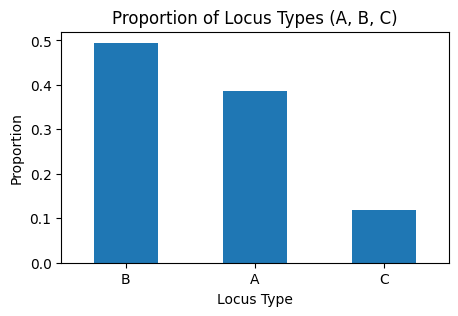

B    0.494986
A    0.386304
C    0.118710
Name: Locus, dtype: float64


In [16]:
### HLA Class 1 alleles
df.loc[:, 'Locus'] = df['allele'].apply(lambda x: x.split('-')[1].split('*')[0])
locus_counts = df['Locus'].value_counts()
locus_proportions = locus_counts / len(df)
plt.figure(figsize=(5, 3))
locus_proportions.plot(kind='bar')
plt.title('Proportion of Locus Types (A, B, C)')
plt.xlabel('Locus Type')
plt.ylabel('Proportion')
plt.xticks(rotation=0)
plt.show()
print(locus_proportions)

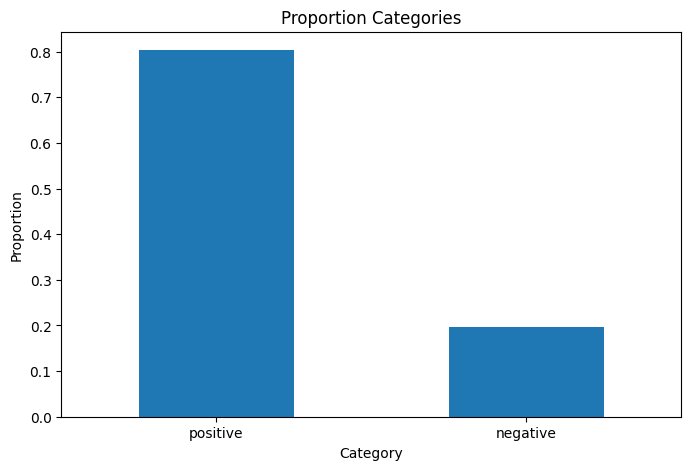

positive    0.803718
negative    0.196282
Name: label, dtype: float64

In [17]:
category_counts = df['label'].value_counts()
category_proportions = category_counts /len(df)
plt.figure(figsize=(8, 5))
category_proportions.plot(kind='bar')
plt.title('Proportion Categories')
plt.xlabel('Category')
plt.ylabel('Proportion')
plt.xticks(rotation=0)
plt.show()
category_proportions

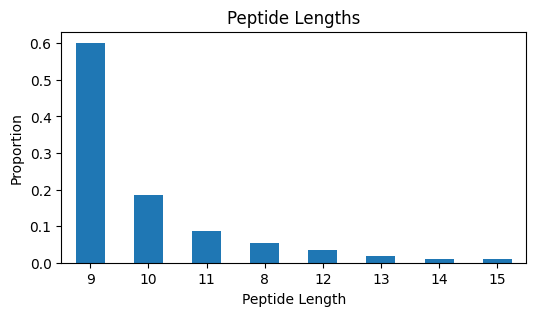

In [18]:
# Length of peptide sequences
df['peptide_length'] = df['peptide'].apply(len)
df.head()
unique_peptide_lengths = df['peptide_length'].value_counts()
unique_peptide_lengths
peptide_length_proportions = unique_peptide_lengths / unique_peptide_lengths.sum()
plt.figure(figsize=(6, 3))
peptide_length_proportions.plot(kind='bar')
plt.title('Peptide Lengths')
plt.xlabel('Peptide Length')
plt.ylabel('Proportion')
plt.xticks(rotation=0)
plt.show()

In [19]:
unique_peptide_lengths

9     397758
10    121580
11     58148
8      35848
12     23062
13     11716
14      7178
15      5902
Name: peptide_length, dtype: int64

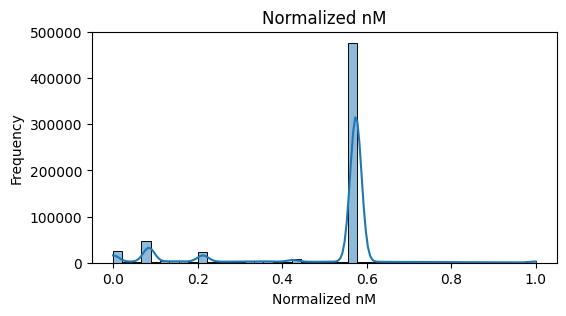

In [20]:
plt.figure(figsize=(6, 3))
sns.histplot(df['Normalized nM'], kde=True, bins=45)
plt.title('Normalized nM')
plt.xlabel('Normalized nM')
plt.ylabel('Frequency')
plt.show()

In [21]:
df.to_csv("/home/hamdaalhosani/features-pHLA-main/Data/big_train_sample.csv")

## Stratified Sample 

In [ ]:
df['Normalized nM_cat'] = pd.qcut(df['Normalized nM'], q=10, duplicates='drop')
print(df.shape)

# # Stratifying the sample based on 'Normalized nM_cat', 'Locus', and 'category'
sample_df, rev_df = train_test_split(df, test_size=500000/600000, 
                                 stratify=df[['Normalized nM_cat', 'Locus', 'category']], 
                                 random_state=0)

# # Dropping the temporary category column
sample_df = sample_df.drop('Normalized nM_cat', axis=1)
rev_df = rev_df.drop('Normalized nM_cat',axis=1)

# # Resetting index of the sample_df
sample_df = sample_df.reset_index(drop=True)
rev_df = rev_df.reset_index(drop=True)

# # Displaying the first few rows of the sample_df
print(sample_df.shape)
print(rev_df.shape)

In [ ]:
# # Function to plot proportions
def plot_proportions(df1, df2, column, title):
     fig, axes = plt.subplots(1, 2, figsize=(6, 3), sharey=True)
     df1[column].value_counts(normalize=True).plot(kind='bar', ax=axes[0], title=f'{title} in Full Dataset')
     df2[column].value_counts(normalize=True).plot(kind='bar', ax=axes[1], title=f'{title} in Sample Dataset')
     plt.show()

# # Plotting proportions for 'category'
plot_proportions(rev_df, sample_df, 'label', 'Proportions')

In [ ]:
# # Plotting proportions for 'Locus'
plot_proportions(rev_df, sample_df, 'Locus', 'Locus Proportions')

In [ ]:
# # Function to plot distribution
def plot_distribution(df1, df2, column, title):
     fig, axes = plt.subplots(1, 2, figsize=(10, 5))
     df1[column].plot(kind='hist', bins=30, alpha=0.5, ax=axes[0], title=f'{title} in Full Dataset')
     df2[column].plot(kind='hist', bins=30, alpha=0.5, ax=axes[1], title=f'{title} in Sample Dataset')
     axes[0].set_xlabel(column)
     axes[1].set_xlabel(column)
     plt.show()

# # Usage example:
#plot_distribution(rev_df, sample_df, 'Normalized nM', 'Normalized nM Distribution')

In [ ]:
from scipy.stats import chi2_contingency, ks_2samp

#Chi-squared test for 'category'
category_table = pd.crosstab(index=rev_df['category'], columns='count')
sample_category_table = pd.crosstab(index=sample_df['category'], columns='count')
chi2_category, p_category, dof_category, _ = chi2_contingency([category_table.values, sample_category_table.values])

#Chi-squared test for 'Locus'
locus_table = pd.crosstab(index=rev_df['Locus'], columns='count')
sample_locus_table = pd.crosstab(index=sample_df['Locus'], columns='count')
chi2_locus, p_locus, dof_locus, _ = chi2_contingency([locus_table.values, sample_locus_table.values])

# # KS test for 'Normalized nM'
ks_statistic_nm, p_value_nm = ks_2samp(rev_df['Normalized nM'], sample_df['Normalized nM'])

# # Creating a table for the results
stat_results = {
     'Test': ['Chi-squared for Category', 'Chi-squared for Locus', 'KS Test for Normalized nM'],
     'Statistic': [chi2_category, chi2_locus, ks_statistic_nm],
     'P-Value': [p_category, p_locus, p_value_nm]
 }

stat_df = pd.DataFrame(stat_results)
stat_df

In [ ]:
sample_df.to_csv('../../Data/big_test_sample.csv') 
rev_df.to_csv('../../Data/big_train_sample.csv')